# Previsão do Preço do Bitcoin com LSTM
 
**Framework:** TensorFlow/Keras

**Requerimentos:** 

    1.Python 3.9
    2.Tensorflow == 2.15.0
    3.Pandas
    4.Matplotlib
    5.Baixar o dataset no local: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

## Etapas do Projeto:
    1. Carregamento e Exploração dos Dados
    2. Pré-processamento
    3. Criação do Modelo LSTM
    4. Treinamento e Validação
    5. Avaliação e Previsões




# Importação de Bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


import optuna
from tensorflow.keras.optimizers import Adam

# 1. Carregamento e Exploração dos Dados

In [3]:
# Carregar o arquivo CSV (ajuste o caminho conforme necessário)
df = pd.read_csv('btcusd_1-min_data.csv')

In [4]:
df

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
6750276,1.737936e+09,102628.00,102669.00,102608.00,102611.00,0.086742
6750277,1.737936e+09,102659.00,102712.00,102657.00,102712.00,0.488757
6750278,1.737936e+09,102631.00,102631.00,102573.00,102573.00,0.126719
6750279,1.737936e+09,102573.00,102604.00,102507.00,102514.00,0.474495


In [5]:
# Converter timestamp para datetime
df['date'] = pd.to_datetime(df['Timestamp'], unit='s')
df.head()

,Timestamp,Open,High,Low,Close,Volume,date
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00


In [6]:

print("\nInformações do Dataset:")
df.info()


Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750281 entries, 0 to 6750280
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Timestamp  float64       
 1   Open       float64       
 2   High       float64       
 3   Low        float64       
 4   Close      float64       
 5   Volume     float64       
 6   date       datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 360.5 MB


## Pré-processamento Inicial

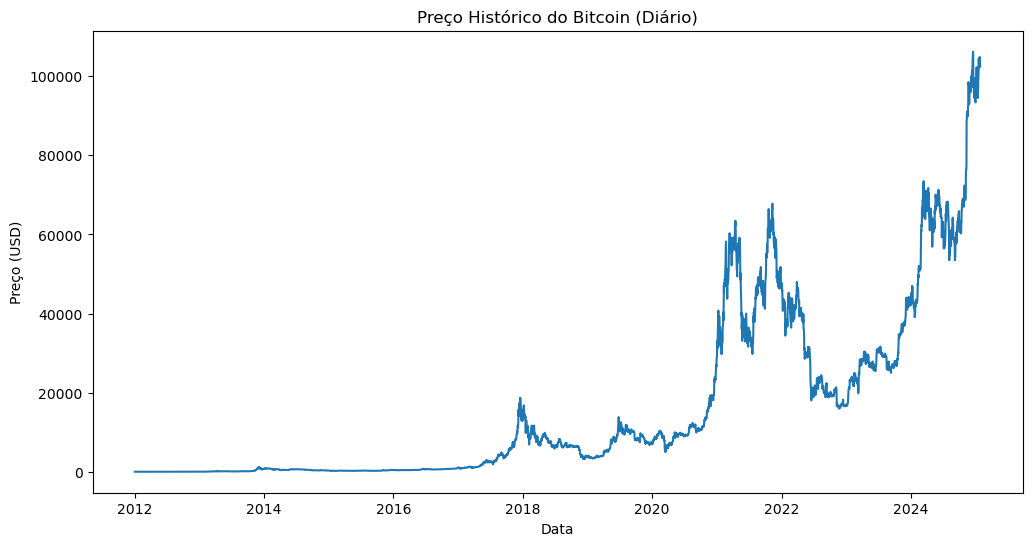

In [7]:
# Converter dados de 1 minuto para diários
df_daily = df.resample('D', on='date').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum',
    
}).dropna()

# Plot do preço de fechamento
plt.figure(figsize=(12,6))
plt.plot(df_daily.index, df_daily['Close'])
plt.title('Preço Histórico do Bitcoin (Diário)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.show()

# 2. Pré-processamento para LSTM

In [8]:
# Usaremos apenas o preço de fechamento
data = df_daily[['Close']].values

# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Divisão entre treino e teste
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [9]:
# Função para criar sequências
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60  # Janela temporal de 60 dias
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# 3. Utilização do Opituna para testar variações:

In [15]:


def objective(trial):
    # Sugerir hiperparâmetros
    lstm1_units = trial.suggest_int('lstm1_units', 50, 100 ,step=10)
    lstm2_units = trial.suggest_int('lstm2_units', 100, 200, step=10)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    dense_units = trial.suggest_int('dense_units',10, 50,  step=10)
    batch_size = trial.suggest_int('batch_size', 16, 64, step=16)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    # Construir o modelo com os hiperparâmetros sugeridos
    model = Sequential()
    model.add(LSTM(lstm1_units, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm2_units, return_sequences=False))
    model.add(Dense(dense_units))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        epochs=10,            # Usando 100 épocas para acelerar os trials
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Retornar o menor valor de validação (loss)
    val_loss = min(history.history['val_loss'])
    return val_loss

# Criar estudo e executar os trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Exibir o melhor trial encontrado
print("Melhor Trial:")
print("Parâmetros:", study.best_trial.params)
print("Validação Loss:", study.best_trial.value)





[I 2025-02-08 02:25:39,835] A new study created in memory with name: no-name-e4988d3c-7036-4278-a2ff-a8fdae9f6d2a
C:\Users\Erick\AppData\Local\Temp\ipykernel_16992\450094897.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


Epoch 1/10
188/188 [==============================] - 11s 43ms/step - loss: 8.5691e-05 - val_loss: 0.0012
Epoch 2/10
188/188 [==============================] - 7s 39ms/step - loss: 3.1010e-05 - val_loss: 5.6007e-04
Epoch 3/10
188/188 [==============================] - 8s 41ms/step - loss: 3.3484e-05 - val_loss: 0.0025
Epoch 4/10
188/188 [==============================] - 8s 43ms/step - loss: 2.9204e-05 - val_loss: 7.7309e-04
Epoch 5/10
188/188 [==============================] - 8s 44ms/step - loss: 2.8817e-05 - val_loss: 5.2303e-04
Epoch 6/10
188/188 [==============================] - 8s 41ms/step - loss: 2.5686e-05 - val_loss: 8.1302e-04
Epoch 7/10
188/188 [==============================] - 7s 39ms/step - loss: 2.5001e-05 - val_loss: 5.0206e-04
Epoch 8/10
188/188 [==============================] - 7s 39ms/step - loss: 2.5095e-05 - val_loss: 0.0016
Epoch 9/10
188/188 [==============================] - 8s 42ms/step - loss: 2.7500e-05 - val_loss: 0.0013
Epoch 10/10
188/188 [=============

[I 2025-02-08 02:27:01,132] Trial 0 finished with value: 0.000502057489939034 and parameters: {'lstm1_units': 90, 'lstm2_units': 190, 'dropout_rate': 0.5, 'dense_units': 10, 'batch_size': 16, 'learning_rate': 0.0013160159885620627}. Best is trial 0 with value: 0.000502057489939034.


Epoch 1/10
47/47 [==============================] - 7s 80ms/step - loss: 2.4775e-04 - val_loss: 0.0011
Epoch 2/10
47/47 [==============================] - 3s 65ms/step - loss: 3.2458e-05 - val_loss: 0.0011
Epoch 3/10
47/47 [==============================] - 3s 57ms/step - loss: 3.3482e-05 - val_loss: 0.0011
Epoch 4/10
47/47 [==============================] - 3s 57ms/step - loss: 2.7325e-05 - val_loss: 0.0011
Epoch 5/10
47/47 [==============================] - 3s 56ms/step - loss: 2.6275e-05 - val_loss: 8.5487e-04
Epoch 6/10
47/47 [==============================] - 3s 56ms/step - loss: 2.5089e-05 - val_loss: 9.5219e-04
Epoch 7/10
47/47 [==============================] - 3s 56ms/step - loss: 2.4260e-05 - val_loss: 7.3896e-04
Epoch 8/10
47/47 [==============================] - 3s 58ms/step - loss: 2.4031e-05 - val_loss: 9.9578e-04
Epoch 9/10
47/47 [==============================] - 3s 57ms/step - loss: 2.5881e-05 - val_loss: 9.1435e-04
Epoch 10/10
47/47 [==============================] - 

[I 2025-02-08 02:27:32,923] Trial 1 finished with value: 0.0007389553356915712 and parameters: {'lstm1_units': 50, 'lstm2_units': 150, 'dropout_rate': 0.4, 'dense_units': 50, 'batch_size': 64, 'learning_rate': 0.00040100948722034867}. Best is trial 0 with value: 0.000502057489939034.


Epoch 1/10
63/63 [==============================] - 6s 59ms/step - loss: 6.7041e-04 - val_loss: 0.0022
Epoch 2/10
63/63 [==============================] - 3s 49ms/step - loss: 4.7147e-05 - val_loss: 0.0017
Epoch 3/10
63/63 [==============================] - 3s 49ms/step - loss: 4.2906e-05 - val_loss: 0.0016
Epoch 4/10
63/63 [==============================] - 3s 49ms/step - loss: 4.2788e-05 - val_loss: 0.0015
Epoch 5/10
63/63 [==============================] - 3s 50ms/step - loss: 4.2633e-05 - val_loss: 0.0015
Epoch 6/10
63/63 [==============================] - 3s 50ms/step - loss: 4.1485e-05 - val_loss: 0.0014
Epoch 7/10
63/63 [==============================] - 3s 49ms/step - loss: 3.9056e-05 - val_loss: 0.0015
Epoch 8/10
63/63 [==============================] - 3s 49ms/step - loss: 3.8678e-05 - val_loss: 0.0014
Epoch 9/10
63/63 [==============================] - 3s 50ms/step - loss: 3.6514e-05 - val_loss: 0.0013
Epoch 10/10
63/63 [==============================] - 3s 49ms/step - loss:

[I 2025-02-08 02:28:07,917] Trial 2 finished with value: 0.0012799773830920458 and parameters: {'lstm1_units': 70, 'lstm2_units': 140, 'dropout_rate': 0.4, 'dense_units': 20, 'batch_size': 48, 'learning_rate': 6.206154824645878e-05}. Best is trial 0 with value: 0.000502057489939034.


Epoch 1/10
94/94 [==============================] - 8s 58ms/step - loss: 1.3848e-04 - val_loss: 6.8753e-04
Epoch 2/10
94/94 [==============================] - 5s 52ms/step - loss: 3.0042e-05 - val_loss: 0.0010
Epoch 3/10
94/94 [==============================] - 5s 52ms/step - loss: 2.5400e-05 - val_loss: 6.3304e-04
Epoch 4/10
94/94 [==============================] - 5s 52ms/step - loss: 2.3116e-05 - val_loss: 7.1002e-04
Epoch 5/10
94/94 [==============================] - 5s 52ms/step - loss: 2.7086e-05 - val_loss: 0.0025
Epoch 6/10
94/94 [==============================] - 5s 52ms/step - loss: 2.2554e-05 - val_loss: 4.5600e-04
Epoch 7/10
94/94 [==============================] - 5s 52ms/step - loss: 2.6490e-05 - val_loss: 9.4927e-04
Epoch 8/10
94/94 [==============================] - 5s 53ms/step - loss: 2.2510e-05 - val_loss: 6.8498e-04
Epoch 9/10
94/94 [==============================] - 5s 53ms/step - loss: 1.7736e-05 - val_loss: 0.0011
Epoch 10/10
94/94 [==============================

[I 2025-02-08 02:29:00,838] Trial 3 finished with value: 0.00045599977602250874 and parameters: {'lstm1_units': 90, 'lstm2_units': 190, 'dropout_rate': 0.4, 'dense_units': 30, 'batch_size': 32, 'learning_rate': 0.0018573512537108845}. Best is trial 3 with value: 0.00045599977602250874.


Epoch 1/10
47/47 [==============================] - 7s 76ms/step - loss: 0.0014 - val_loss: 0.0812
Epoch 2/10
47/47 [==============================] - 3s 61ms/step - loss: 6.1294e-04 - val_loss: 0.0245
Epoch 3/10
47/47 [==============================] - 3s 61ms/step - loss: 1.0879e-04 - val_loss: 0.0022
Epoch 4/10
47/47 [==============================] - 3s 61ms/step - loss: 5.0274e-05 - val_loss: 0.0019
Epoch 5/10
47/47 [==============================] - 3s 61ms/step - loss: 4.9390e-05 - val_loss: 0.0019
Epoch 6/10
47/47 [==============================] - 3s 62ms/step - loss: 4.8251e-05 - val_loss: 0.0018
Epoch 7/10
47/47 [==============================] - 3s 61ms/step - loss: 4.7717e-05 - val_loss: 0.0018
Epoch 8/10
47/47 [==============================] - 3s 62ms/step - loss: 4.6140e-05 - val_loss: 0.0017
Epoch 9/10
47/47 [==============================] - 3s 60ms/step - loss: 4.5008e-05 - val_loss: 0.0017
Epoch 10/10
47/47 [==============================] - 3s 61ms/step - loss: 4.4

[I 2025-02-08 02:29:33,734] Trial 4 finished with value: 0.001661569345742464 and parameters: {'lstm1_units': 100, 'lstm2_units': 100, 'dropout_rate': 0.4, 'dense_units': 40, 'batch_size': 64, 'learning_rate': 3.933054182352834e-05}. Best is trial 3 with value: 0.00045599977602250874.


Epoch 1/10
94/94 [==============================] - 7s 40ms/step - loss: 1.1682e-04 - val_loss: 9.6270e-04
Epoch 2/10
94/94 [==============================] - 3s 35ms/step - loss: 2.6296e-05 - val_loss: 8.4525e-04
Epoch 3/10
94/94 [==============================] - 3s 34ms/step - loss: 2.3207e-05 - val_loss: 6.9267e-04
Epoch 4/10
94/94 [==============================] - 3s 36ms/step - loss: 2.3001e-05 - val_loss: 8.9826e-04
Epoch 5/10
94/94 [==============================] - 3s 33ms/step - loss: 1.9807e-05 - val_loss: 5.7193e-04
Epoch 6/10
94/94 [==============================] - 3s 34ms/step - loss: 1.8441e-05 - val_loss: 5.6759e-04
Epoch 7/10
94/94 [==============================] - 3s 35ms/step - loss: 1.8260e-05 - val_loss: 5.0191e-04
Epoch 8/10
94/94 [==============================] - 3s 34ms/step - loss: 1.7592e-05 - val_loss: 6.9447e-04
Epoch 9/10
94/94 [==============================] - 3s 34ms/step - loss: 1.5822e-05 - val_loss: 5.1747e-04
Epoch 10/10
94/94 [==================

[I 2025-02-08 02:30:09,846] Trial 5 finished with value: 0.0005019099917262793 and parameters: {'lstm1_units': 60, 'lstm2_units': 110, 'dropout_rate': 0.1, 'dense_units': 20, 'batch_size': 32, 'learning_rate': 0.0005784224262656111}. Best is trial 3 with value: 0.00045599977602250874.


Epoch 1/10
94/94 [==============================] - 8s 59ms/step - loss: 1.1713e-04 - val_loss: 9.1081e-04
Epoch 2/10
94/94 [==============================] - 5s 53ms/step - loss: 2.5045e-05 - val_loss: 0.0014
Epoch 3/10
94/94 [==============================] - 5s 53ms/step - loss: 2.0139e-05 - val_loss: 6.4418e-04
Epoch 4/10
94/94 [==============================] - 5s 53ms/step - loss: 1.8502e-05 - val_loss: 0.0013
Epoch 5/10
94/94 [==============================] - 5s 52ms/step - loss: 1.7315e-05 - val_loss: 0.0012
Epoch 6/10
94/94 [==============================] - 5s 54ms/step - loss: 1.8556e-05 - val_loss: 5.1182e-04
Epoch 7/10
94/94 [==============================] - 5s 55ms/step - loss: 1.6260e-05 - val_loss: 3.9319e-04
Epoch 8/10
94/94 [==============================] - 5s 53ms/step - loss: 2.4564e-05 - val_loss: 3.7006e-04
Epoch 9/10
94/94 [==============================] - 5s 54ms/step - loss: 1.2626e-05 - val_loss: 5.4122e-04
Epoch 10/10
94/94 [==============================

[I 2025-02-08 02:31:03,794] Trial 6 finished with value: 0.00037006111233495176 and parameters: {'lstm1_units': 80, 'lstm2_units': 200, 'dropout_rate': 0.1, 'dense_units': 10, 'batch_size': 32, 'learning_rate': 0.0015856780114931028}. Best is trial 6 with value: 0.00037006111233495176.


Epoch 1/10
47/47 [==============================] - 6s 78ms/step - loss: 3.2299e-04 - val_loss: 9.9752e-04
Epoch 2/10
47/47 [==============================] - 3s 66ms/step - loss: 3.1391e-05 - val_loss: 0.0011
Epoch 3/10
47/47 [==============================] - 3s 65ms/step - loss: 2.9147e-05 - val_loss: 0.0019
Epoch 4/10
47/47 [==============================] - 3s 65ms/step - loss: 3.0194e-05 - val_loss: 9.6941e-04
Epoch 5/10
47/47 [==============================] - 3s 65ms/step - loss: 2.7857e-05 - val_loss: 8.3202e-04
Epoch 6/10
47/47 [==============================] - 3s 66ms/step - loss: 2.7646e-05 - val_loss: 5.7670e-04
Epoch 7/10
47/47 [==============================] - 3s 67ms/step - loss: 2.4348e-05 - val_loss: 0.0015
Epoch 8/10
47/47 [==============================] - 3s 67ms/step - loss: 2.2915e-05 - val_loss: 6.0905e-04
Epoch 9/10
47/47 [==============================] - 3s 66ms/step - loss: 2.0137e-05 - val_loss: 4.8624e-04
Epoch 10/10
47/47 [==============================

[I 2025-02-08 02:31:38,648] Trial 7 finished with value: 0.0004862350469920784 and parameters: {'lstm1_units': 50, 'lstm2_units': 180, 'dropout_rate': 0.4, 'dense_units': 40, 'batch_size': 64, 'learning_rate': 0.0022909039866753737}. Best is trial 6 with value: 0.00037006111233495176.


Epoch 1/10
94/94 [==============================] - 7s 48ms/step - loss: 4.4415e-04 - val_loss: 0.0017
Epoch 2/10
94/94 [==============================] - 4s 41ms/step - loss: 4.3906e-05 - val_loss: 0.0016
Epoch 3/10
94/94 [==============================] - 4s 41ms/step - loss: 4.2517e-05 - val_loss: 0.0017
Epoch 4/10
94/94 [==============================] - 5s 55ms/step - loss: 4.0027e-05 - val_loss: 0.0016
Epoch 5/10
94/94 [==============================] - 5s 49ms/step - loss: 3.7376e-05 - val_loss: 0.0014
Epoch 6/10
94/94 [==============================] - 5s 56ms/step - loss: 3.4674e-05 - val_loss: 0.0013
Epoch 7/10
94/94 [==============================] - 7s 69ms/step - loss: 3.3995e-05 - val_loss: 0.0013
Epoch 8/10
94/94 [==============================] - 5s 50ms/step - loss: 3.2479e-05 - val_loss: 0.0013
Epoch 9/10
94/94 [==============================] - 5s 49ms/step - loss: 3.1068e-05 - val_loss: 0.0012
Epoch 10/10
94/94 [==============================] - 5s 53ms/step - loss:

[I 2025-02-08 02:32:30,393] Trial 8 finished with value: 0.001177959144115448 and parameters: {'lstm1_units': 60, 'lstm2_units': 140, 'dropout_rate': 0.1, 'dense_units': 30, 'batch_size': 32, 'learning_rate': 4.2959571430804035e-05}. Best is trial 6 with value: 0.00037006111233495176.


Epoch 1/10
188/188 [==============================] - 12s 49ms/step - loss: 8.4325e-05 - val_loss: 6.6875e-04
Epoch 2/10
188/188 [==============================] - 7s 40ms/step - loss: 3.0093e-05 - val_loss: 7.6474e-04
Epoch 3/10
188/188 [==============================] - 8s 44ms/step - loss: 2.4218e-05 - val_loss: 5.2302e-04
Epoch 4/10
188/188 [==============================] - 8s 42ms/step - loss: 2.5947e-05 - val_loss: 4.6773e-04
Epoch 5/10
188/188 [==============================] - 7s 39ms/step - loss: 2.9216e-05 - val_loss: 3.9562e-04
Epoch 6/10
188/188 [==============================] - 8s 40ms/step - loss: 2.3998e-05 - val_loss: 6.1167e-04
Epoch 7/10
188/188 [==============================] - 8s 41ms/step - loss: 2.7267e-05 - val_loss: 0.0023
Epoch 8/10
188/188 [==============================] - 7s 39ms/step - loss: 2.1099e-05 - val_loss: 6.9615e-04
Epoch 9/10
188/188 [==============================] - 7s 39ms/step - loss: 2.8340e-05 - val_loss: 0.0012
Epoch 10/10
188/188 [=====

[I 2025-02-08 02:33:51,449] Trial 9 finished with value: 0.00039561817538924515 and parameters: {'lstm1_units': 90, 'lstm2_units': 180, 'dropout_rate': 0.4, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.0014028565520086244}. Best is trial 6 with value: 0.00037006111233495176.


Epoch 1/10
63/63 [==============================] - 7s 74ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2/10
63/63 [==============================] - 4s 65ms/step - loss: 3.8063e-05 - val_loss: 0.0012
Epoch 3/10
63/63 [==============================] - 4s 64ms/step - loss: 2.7222e-05 - val_loss: 0.0013
Epoch 4/10
63/63 [==============================] - 4s 65ms/step - loss: 2.4824e-05 - val_loss: 0.0018
Epoch 5/10
63/63 [==============================] - 4s 65ms/step - loss: 3.2775e-05 - val_loss: 0.0029
Epoch 6/10
63/63 [==============================] - 4s 65ms/step - loss: 2.2990e-05 - val_loss: 0.0025
Epoch 7/10
63/63 [==============================] - 4s 66ms/step - loss: 2.1245e-05 - val_loss: 0.0012
Epoch 8/10
63/63 [==============================] - 4s 64ms/step - loss: 2.1509e-05 - val_loss: 0.0011
Epoch 9/10
63/63 [==============================] - 4s 66ms/step - loss: 2.1951e-05 - val_loss: 0.0025


[I 2025-02-08 02:34:32,148] Trial 10 finished with value: 0.0011002434184774756 and parameters: {'lstm1_units': 80, 'lstm2_units': 200, 'dropout_rate': 0.2, 'dense_units': 10, 'batch_size': 48, 'learning_rate': 0.007497088515450963}. Best is trial 6 with value: 0.00037006111233495176.


Epoch 1/10
188/188 [==============================] - 10s 40ms/step - loss: 4.3941e-04 - val_loss: 6.3132e-04
Epoch 2/10
188/188 [==============================] - 7s 37ms/step - loss: 3.6266e-05 - val_loss: 5.5530e-04
Epoch 3/10
188/188 [==============================] - 7s 37ms/step - loss: 3.5278e-05 - val_loss: 0.0011
Epoch 4/10
188/188 [==============================] - 7s 36ms/step - loss: 2.6406e-05 - val_loss: 5.1952e-04
Epoch 5/10
188/188 [==============================] - 7s 37ms/step - loss: 2.8188e-05 - val_loss: 0.0019
Epoch 6/10
188/188 [==============================] - 7s 37ms/step - loss: 2.8962e-05 - val_loss: 4.2971e-04
Epoch 7/10
188/188 [==============================] - 7s 37ms/step - loss: 2.6239e-05 - val_loss: 0.0013
Epoch 8/10
188/188 [==============================] - 7s 38ms/step - loss: 2.3183e-05 - val_loss: 0.0017
Epoch 9/10
188/188 [==============================] - 7s 38ms/step - loss: 3.3705e-05 - val_loss: 6.0712e-04
Epoch 10/10
188/188 [=============

[I 2025-02-08 02:35:45,439] Trial 11 finished with value: 0.00042970903450623155 and parameters: {'lstm1_units': 80, 'lstm2_units': 170, 'dropout_rate': 0.2, 'dense_units': 50, 'batch_size': 16, 'learning_rate': 0.0065861591905812256}. Best is trial 6 with value: 0.00037006111233495176.


Epoch 1/10
188/188 [==============================] - 11s 43ms/step - loss: 1.3330e-04 - val_loss: 0.0018
Epoch 2/10
188/188 [==============================] - 8s 43ms/step - loss: 3.0743e-05 - val_loss: 0.0012
Epoch 3/10
188/188 [==============================] - 9s 49ms/step - loss: 2.6315e-05 - val_loss: 7.9510e-04
Epoch 4/10
188/188 [==============================] - 9s 46ms/step - loss: 2.6750e-05 - val_loss: 7.2072e-04
Epoch 5/10
188/188 [==============================] - 10s 54ms/step - loss: 2.2175e-05 - val_loss: 8.2659e-04
Epoch 6/10
188/188 [==============================] - 9s 49ms/step - loss: 2.0700e-05 - val_loss: 6.3992e-04
Epoch 7/10
188/188 [==============================] - 9s 46ms/step - loss: 2.0674e-05 - val_loss: 5.7290e-04
Epoch 8/10
188/188 [==============================] - 9s 46ms/step - loss: 1.8181e-05 - val_loss: 0.0012
Epoch 9/10
188/188 [==============================] - 8s 45ms/step - loss: 1.9118e-05 - val_loss: 9.4487e-04
Epoch 10/10
188/188 [========

[I 2025-02-08 02:37:16,413] Trial 12 finished with value: 0.0005729038966819644 and parameters: {'lstm1_units': 100, 'lstm2_units': 170, 'dropout_rate': 0.30000000000000004, 'dense_units': 20, 'batch_size': 16, 'learning_rate': 0.00018139425018129523}. Best is trial 6 with value: 0.00037006111233495176.


Epoch 1/10
188/188 [==============================] - 12s 48ms/step - loss: 6.7512e-05 - val_loss: 7.9429e-04
Epoch 2/10
188/188 [==============================] - 8s 45ms/step - loss: 2.8586e-05 - val_loss: 0.0021
Epoch 3/10
188/188 [==============================] - 8s 44ms/step - loss: 2.3028e-05 - val_loss: 0.0010
Epoch 4/10
188/188 [==============================] - 9s 47ms/step - loss: 2.3256e-05 - val_loss: 3.9758e-04
Epoch 5/10
188/188 [==============================] - 9s 50ms/step - loss: 1.9667e-05 - val_loss: 4.9443e-04
Epoch 6/10
188/188 [==============================] - 9s 45ms/step - loss: 1.8211e-05 - val_loss: 0.0010
Epoch 7/10
188/188 [==============================] - 8s 45ms/step - loss: 1.6269e-05 - val_loss: 6.4234e-04
Epoch 8/10
188/188 [==============================] - 8s 42ms/step - loss: 1.6367e-05 - val_loss: 3.1588e-04
Epoch 9/10
188/188 [==============================] - 9s 48ms/step - loss: 1.9203e-05 - val_loss: 8.6406e-04
Epoch 10/10
188/188 [=========

[I 2025-02-08 02:38:45,430] Trial 13 finished with value: 0.00030458869878202677 and parameters: {'lstm1_units': 90, 'lstm2_units': 200, 'dropout_rate': 0.2, 'dense_units': 40, 'batch_size': 16, 'learning_rate': 0.000902114568356005}. Best is trial 13 with value: 0.00030458869878202677.


Epoch 1/10
94/94 [==============================] - 11s 82ms/step - loss: 1.7999e-04 - val_loss: 0.0014
Epoch 2/10
94/94 [==============================] - 5s 58ms/step - loss: 3.3369e-05 - val_loss: 0.0015
Epoch 3/10
94/94 [==============================] - 6s 64ms/step - loss: 3.0453e-05 - val_loss: 0.0010
Epoch 4/10
94/94 [==============================] - 6s 64ms/step - loss: 2.7902e-05 - val_loss: 0.0012
Epoch 5/10
94/94 [==============================] - 6s 59ms/step - loss: 2.4736e-05 - val_loss: 9.9985e-04
Epoch 6/10
94/94 [==============================] - 6s 61ms/step - loss: 2.4143e-05 - val_loss: 0.0012
Epoch 7/10
94/94 [==============================] - 7s 69ms/step - loss: 2.4782e-05 - val_loss: 8.9845e-04
Epoch 8/10
94/94 [==============================] - 7s 73ms/step - loss: 2.3346e-05 - val_loss: 0.0016
Epoch 9/10
94/94 [==============================] - 7s 70ms/step - loss: 2.4155e-05 - val_loss: 0.0013
Epoch 10/10
94/94 [==============================] - 7s 72ms/ste

[I 2025-02-08 02:39:52,619] Trial 14 finished with value: 0.0008984489249996841 and parameters: {'lstm1_units': 70, 'lstm2_units': 200, 'dropout_rate': 0.2, 'dense_units': 40, 'batch_size': 32, 'learning_rate': 0.00015318719846256663}. Best is trial 13 with value: 0.00030458869878202677.


Epoch 1/10
63/63 [==============================] - 8s 75ms/step - loss: 1.1866e-04 - val_loss: 9.9264e-04
Epoch 2/10
63/63 [==============================] - 4s 69ms/step - loss: 2.6953e-05 - val_loss: 0.0012
Epoch 3/10
63/63 [==============================] - 4s 66ms/step - loss: 2.5350e-05 - val_loss: 8.3679e-04
Epoch 4/10
63/63 [==============================] - 4s 70ms/step - loss: 2.2581e-05 - val_loss: 0.0010
Epoch 5/10
63/63 [==============================] - 4s 65ms/step - loss: 2.3868e-05 - val_loss: 7.2413e-04
Epoch 6/10
63/63 [==============================] - 4s 63ms/step - loss: 2.1104e-05 - val_loss: 7.8409e-04
Epoch 7/10
63/63 [==============================] - 4s 65ms/step - loss: 1.8467e-05 - val_loss: 6.4954e-04
Epoch 8/10
63/63 [==============================] - 4s 67ms/step - loss: 1.7847e-05 - val_loss: 5.5223e-04
Epoch 9/10
63/63 [==============================] - 4s 68ms/step - loss: 1.6978e-05 - val_loss: 6.2756e-04
Epoch 10/10
63/63 [==========================

[I 2025-02-08 02:40:39,132] Trial 15 finished with value: 0.0004955065087415278 and parameters: {'lstm1_units': 80, 'lstm2_units': 160, 'dropout_rate': 0.1, 'dense_units': 30, 'batch_size': 48, 'learning_rate': 0.0006015110677350876}. Best is trial 13 with value: 0.00030458869878202677.


Epoch 1/10
188/188 [==============================] - 13s 53ms/step - loss: 6.5741e-04 - val_loss: 0.0063
Epoch 2/10
188/188 [==============================] - 10s 51ms/step - loss: 5.3538e-05 - val_loss: 0.0019
Epoch 3/10
188/188 [==============================] - 10s 52ms/step - loss: 4.7658e-05 - val_loss: 0.0018
Epoch 4/10
188/188 [==============================] - 8s 43ms/step - loss: 4.7405e-05 - val_loss: 0.0018
Epoch 5/10
188/188 [==============================] - 8s 41ms/step - loss: 4.4585e-05 - val_loss: 0.0017
Epoch 6/10
188/188 [==============================] - 8s 40ms/step - loss: 4.2518e-05 - val_loss: 0.0017
Epoch 7/10
188/188 [==============================] - 8s 41ms/step - loss: 4.0809e-05 - val_loss: 0.0016
Epoch 8/10
188/188 [==============================] - 8s 41ms/step - loss: 3.8475e-05 - val_loss: 0.0015
Epoch 9/10
188/188 [==============================] - 8s 41ms/step - loss: 3.6320e-05 - val_loss: 0.0013
Epoch 10/10
188/188 [==============================]

[I 2025-02-08 02:42:06,372] Trial 16 finished with value: 0.0013497013133019209 and parameters: {'lstm1_units': 90, 'lstm2_units': 200, 'dropout_rate': 0.2, 'dense_units': 10, 'batch_size': 16, 'learning_rate': 1.5239877089368856e-05}. Best is trial 13 with value: 0.00030458869878202677.


Epoch 1/10
94/94 [==============================] - 8s 51ms/step - loss: 3.7945e-04 - val_loss: 7.6495e-04
Epoch 2/10
94/94 [==============================] - 5s 49ms/step - loss: 2.9058e-05 - val_loss: 0.0025
Epoch 3/10
94/94 [==============================] - 5s 52ms/step - loss: 2.8179e-05 - val_loss: 6.7740e-04
Epoch 4/10
94/94 [==============================] - 5s 58ms/step - loss: 3.5031e-05 - val_loss: 5.0251e-04
Epoch 5/10
94/94 [==============================] - 6s 60ms/step - loss: 2.1835e-05 - val_loss: 5.1197e-04
Epoch 6/10
94/94 [==============================] - 5s 55ms/step - loss: 2.0987e-05 - val_loss: 8.6952e-04
Epoch 7/10
94/94 [==============================] - 5s 49ms/step - loss: 2.8127e-05 - val_loss: 0.0040
Epoch 8/10
94/94 [==============================] - 5s 49ms/step - loss: 1.9737e-05 - val_loss: 6.1546e-04
Epoch 9/10
94/94 [==============================] - 5s 52ms/step - loss: 1.9956e-05 - val_loss: 0.0032
Epoch 10/10
94/94 [==============================

[I 2025-02-08 02:42:59,670] Trial 17 finished with value: 0.0005025112186558545 and parameters: {'lstm1_units': 100, 'lstm2_units': 120, 'dropout_rate': 0.30000000000000004, 'dense_units': 40, 'batch_size': 32, 'learning_rate': 0.0038050979122336223}. Best is trial 13 with value: 0.00030458869878202677.


Epoch 1/10
188/188 [==============================] - 11s 43ms/step - loss: 8.8329e-05 - val_loss: 7.3392e-04
Epoch 2/10
188/188 [==============================] - 7s 40ms/step - loss: 2.7986e-05 - val_loss: 6.2682e-04
Epoch 3/10
188/188 [==============================] - 8s 40ms/step - loss: 2.1415e-05 - val_loss: 8.2759e-04
Epoch 4/10
188/188 [==============================] - 7s 40ms/step - loss: 2.5635e-05 - val_loss: 8.0088e-04
Epoch 5/10
188/188 [==============================] - 8s 43ms/step - loss: 2.1445e-05 - val_loss: 4.7904e-04
Epoch 6/10
188/188 [==============================] - 8s 43ms/step - loss: 1.5787e-05 - val_loss: 6.9507e-04
Epoch 7/10
188/188 [==============================] - 8s 42ms/step - loss: 1.5082e-05 - val_loss: 5.8731e-04
Epoch 8/10
188/188 [==============================] - 8s 42ms/step - loss: 1.4756e-05 - val_loss: 8.2390e-04
Epoch 9/10
188/188 [==============================] - 7s 38ms/step - loss: 1.2291e-05 - val_loss: 7.9614e-04
Epoch 10/10
188/18

[I 2025-02-08 02:44:19,623] Trial 18 finished with value: 0.0004790443927049637 and parameters: {'lstm1_units': 70, 'lstm2_units': 180, 'dropout_rate': 0.1, 'dense_units': 30, 'batch_size': 16, 'learning_rate': 0.0008434427582462156}. Best is trial 13 with value: 0.00030458869878202677.


Epoch 1/10
94/94 [==============================] - 7s 48ms/step - loss: 2.4678e-04 - val_loss: 0.0015
Epoch 2/10
94/94 [==============================] - 4s 42ms/step - loss: 4.0541e-05 - val_loss: 0.0014
Epoch 3/10
94/94 [==============================] - 4s 44ms/step - loss: 3.5190e-05 - val_loss: 0.0012
Epoch 4/10
94/94 [==============================] - 4s 42ms/step - loss: 3.0537e-05 - val_loss: 0.0011
Epoch 5/10
94/94 [==============================] - 4s 42ms/step - loss: 2.9927e-05 - val_loss: 9.6395e-04
Epoch 6/10
94/94 [==============================] - 4s 42ms/step - loss: 2.8995e-05 - val_loss: 0.0010
Epoch 7/10
94/94 [==============================] - 4s 42ms/step - loss: 2.4799e-05 - val_loss: 8.3476e-04
Epoch 8/10
94/94 [==============================] - 4s 43ms/step - loss: 2.4832e-05 - val_loss: 7.8915e-04
Epoch 9/10
94/94 [==============================] - 4s 43ms/step - loss: 2.2950e-05 - val_loss: 7.6775e-04
Epoch 10/10
94/94 [==============================] - 4s 4

[I 2025-02-08 02:45:03,492] Trial 19 finished with value: 0.0007677452522329986 and parameters: {'lstm1_units': 80, 'lstm2_units': 130, 'dropout_rate': 0.2, 'dense_units': 20, 'batch_size': 32, 'learning_rate': 0.00016251670133229926}. Best is trial 13 with value: 0.00030458869878202677.


Melhor Trial:
Parâmetros: {'lstm1_units': 90, 'lstm2_units': 200, 'dropout_rate': 0.2, 'dense_units': 40, 'batch_size': 16, 'learning_rate': 0.000902114568356005}
Validação Loss: 0.00030458869878202677


## Salvando os Resultados do Optuna em um Arquivo Excel
O dataframe gerado com os resultados de cada trial será salvo no arquivo **optuna_results.xlsx**.


In [16]:
# Gerar DataFrame com os resultados dos trials
df_trials = study.trials_dataframe()

# Salvar em Excel (certifique-se de ter o pacote 'openpyxl' instalado)
df_trials.to_excel("optuna_results.xlsx", index=False)

print("Resultados do Optuna salvos no arquivo 'optuna_results.xlsx'.")

Resultados do Optuna salvos no arquivo 'optuna_results.xlsx'.


In [17]:
pd.read_excel('optuna_results.xlsx')

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dense_units,params_dropout_rate,params_learning_rate,params_lstm1_units,params_lstm2_units,state
0,0,0.000502,2025-02-08 02:25:39.836,2025-02-08 02:27:01.133,0.000941,16,10,0.5,0.001316,90,190,COMPLETE
1,1,0.000739,2025-02-08 02:27:01.133,2025-02-08 02:27:32.923,0.000368,64,50,0.4,0.000401,50,150,COMPLETE
2,2,0.001280,2025-02-08 02:27:32.923,2025-02-08 02:28:07.918,0.000405,48,20,0.4,0.000062,70,140,COMPLETE
3,3,0.000456,2025-02-08 02:28:07.918,2025-02-08 02:29:00.838,0.000613,32,30,0.4,0.001857,90,190,COMPLETE
4,4,0.001662,2025-02-08 02:29:00.838,2025-02-08 02:29:33.734,0.000381,64,40,0.4,0.000039,100,100,COMPLETE
5,5,0.000502,2025-02-08 02:29:33.734,2025-02-08 02:30:09.846,0.000418,32,20,0.1,0.000578,60,110,COMPLETE
6,6,0.000370,2025-02-08 02:30:09.846,2025-02-08 02:31:03.794,0.000624,32,10,0.1,0.001586,80,200,COMPLETE
7,7,0.000486,2025-02-08 02:31:03.795,2025-02-08 02:31:38.649,0.000403,64,40,0.4,0.002291,50,180,COMPLETE
8,8,0.001178,2025-02-08 02:31:38.649,2025-02-08 02:32:30.394,0.000599,32,30,0.1,0.000043,60,140,COMPLETE
9,9,0.000396,2025-02-08 02:32:30.395,2025-02-08 02:33:51.450,0.000938,16,50,0.4,0.001403,90,180,COMPLETE


# 4. Utilizando o Modelo mais eficiente de LSTM encontrado

In [29]:
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(Dropout(0.2))

model.add(LSTM(40, return_sequences=False))

model.add(Dense(20))  # Prevê múltiplos passos (30 dias por vez)
model.add(Dense(1))

/home/yienvee/anaconda3/envs/TF/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:

model.compile(optimizer=Adam(learning_rate=0.0017225280808631136), loss='mean_squared_error')

# Visualizar arquitetura
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (None, 60, 200)        │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 60, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 40)             │        38,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,001 (785.16 KB)

 Trainable params: 201,001 (785.16 KB)

 Non-trainable params: 0 (0.00 B)

# 5. Treinamento do Modelo

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

Epoch 1/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 3.6924e-04 - val_loss: 0.0011
Epoch 2/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 2.1101e-05 - val_loss: 0.0011
Epoch 3/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 1.9324e-05 - val_loss: 5.4341e-04
Epoch 4/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 2.0173e-05 - val_loss: 5.1416e-04
Epoch 5/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 2.0813e-05 - val_loss: 7.3547e-04
Epoch 6/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 1.4079e-05 - val_loss: 6.9524e-04
Epoch 7/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1.5494e-05 - val_loss: 9.9113e-04
Epoch 8/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1.4158e-05 - val_loss: 8.3434e-04
Epoch 9/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 1.7401e-05 - val_loss: 7.2575e-04
Epoch 10/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 1.3336e-05 - val_loss: 9.1685e-04
Epoch 11/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 1.5150

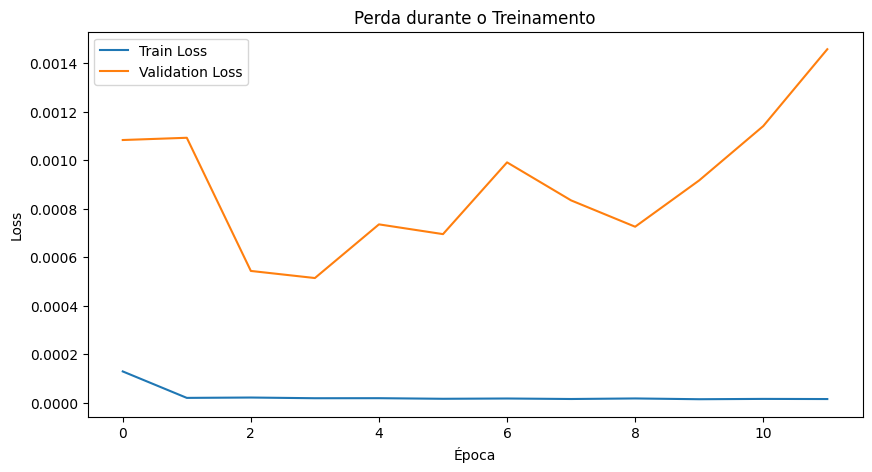

In [35]:
# Aumento de épocas e batch size
history = model.fit(
    X_train, y_train,
    epochs=300,          
    batch_size=32,       
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Plot da perda durante o treinamento
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Perda durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()




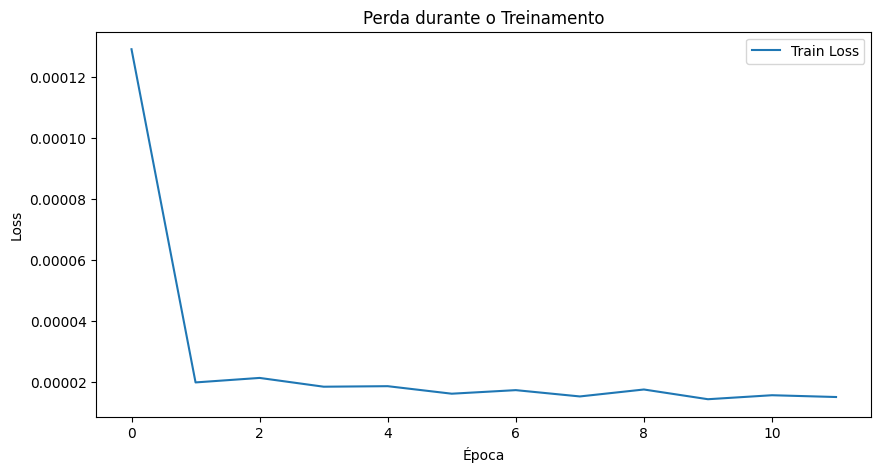

In [36]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Perda durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 6. Avaliação e Previsões

In [38]:
# Fazer previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverter a normalização
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])



118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [39]:
# Deslocar as previsões de treino para alinhar visualmente
train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[SEQ_LENGTH:len(train_predict)+SEQ_LENGTH, :] = train_predict

In [40]:
# Deslocar as previsões de teste
test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(SEQ_LENGTH*2)+1:len(data)-1, :] = test_predict

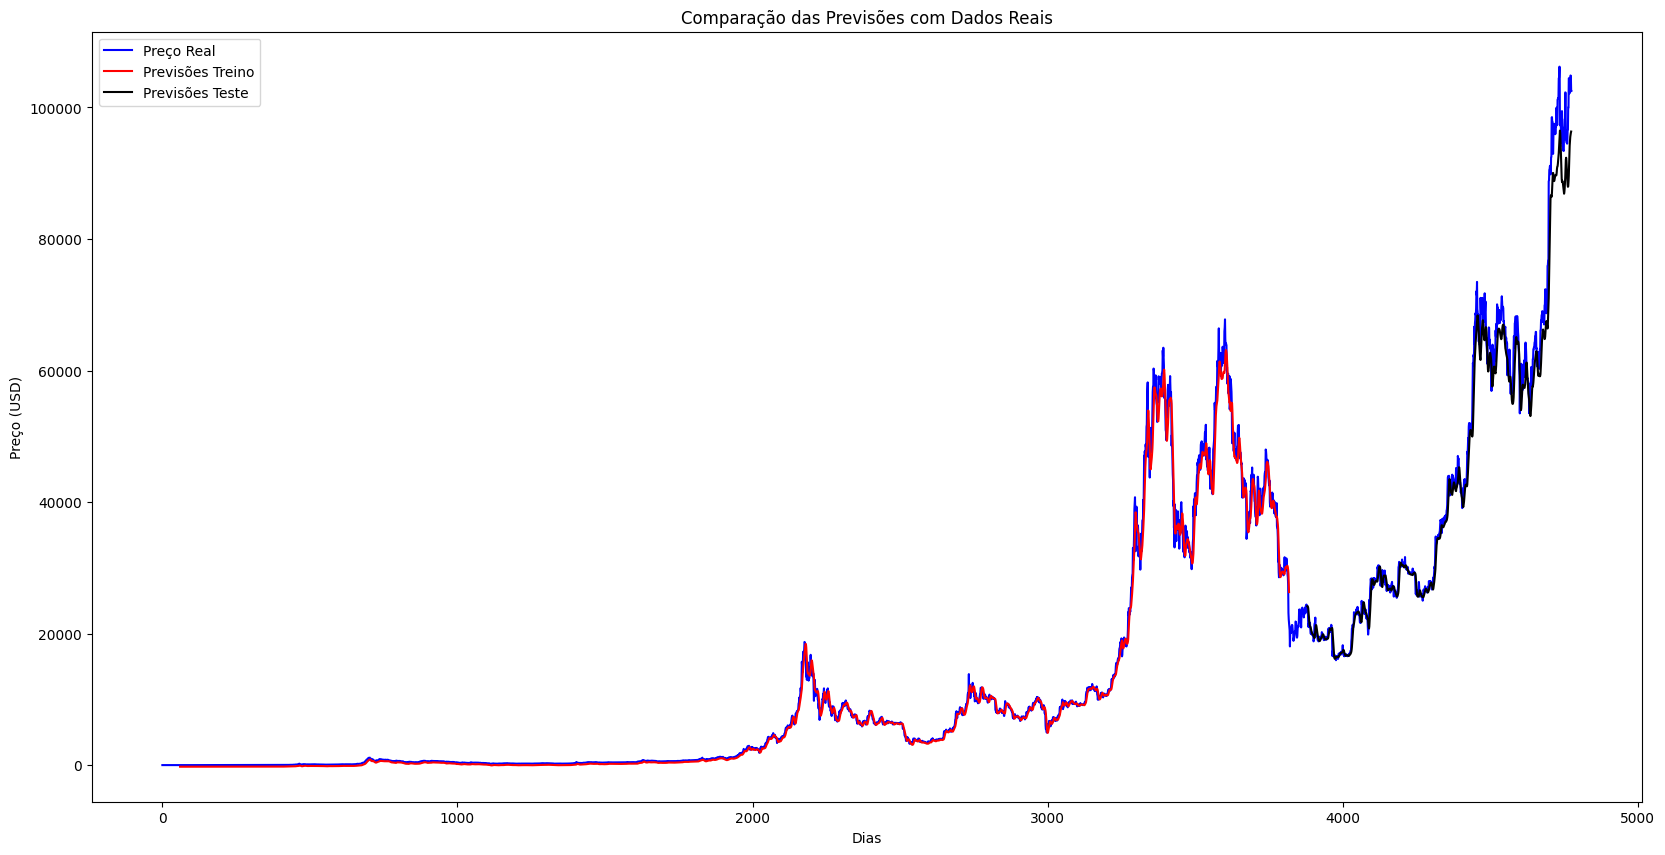

In [41]:
# Plotar tudo
# Plot dos resultados
plt.figure(figsize=(20,10))

plt.plot(data, label='Preço Real', color = 'blue')
plt.plot(train_plot, label='Previsões Treino', color = 'red')
plt.plot(test_plot, label='Previsões Teste', color= 'black')
plt.title('Comparação das Previsões com Dados Reais')
plt.xlabel('Dias')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

## Previsão Futura (Exemplo)

In [22]:
def predict_future(model, last_sequence, days=30):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(days):
        # Fazer previsão
        next_pred = model.predict(current_sequence.reshape(1, SEQ_LENGTH, 1))
        
        # Atualizar a sequência
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
        
        predictions.append(next_pred[0,0])
    
    return scaler.inverse_transform(np.array(predictions).reshape(-1,1))


In [23]:
# Última sequência dos dados de teste
last_sequence = scaled_data[-SEQ_LENGTH:]

# Gerar previsões para 30 dias
future_predictions = predict_future(model, last_sequence, days=365)
print("Previsões para os próximos 30 dias:")
print(future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

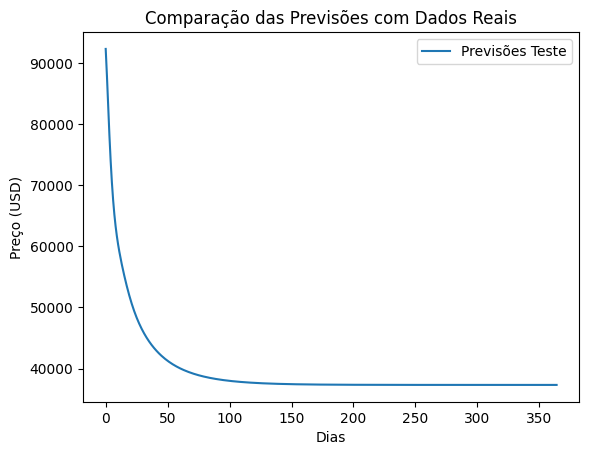

In [24]:
plt.plot(future_predictions, label='Previsões Teste')
plt.title('Comparação das Previsões com Dados Reais')
plt.xlabel('Dias')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

In [ ]:


def objective(trial):
    # Sugerir hiperparâmetros
    lstm1_units = trial.suggest_int('lstm1_units', 50, 200, step=10)
    lstm2_units = trial.suggest_int('lstm2_units', 20, 100, step=10)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    dense_units = trial.suggest_int('dense_units', 10, 50, step=10)
    batch_size = trial.suggest_int('batch_size', 16, 64, step=16)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    # Construir o modelo com os hiperparâmetros sugeridos
    model = Sequential()
    model.add(LSTM(lstm1_units, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm2_units, return_sequences=False))
    model.add(Dense(dense_units))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        epochs=100,            # Usando 100 épocas para acelerar os trials
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Retornar o menor valor de validação (loss)
    val_loss = min(history.history['val_loss'])
    return val_loss

# Criar estudo e executar os trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Exibir o melhor trial encontrado
print("Melhor Trial:")
print("Parâmetros:", study.best_trial.params)
print("Validação Loss:", study.best_trial.value)





/home/yienvee/anaconda3/envs/TF/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-07 13:33:36,080] A new study created in memory with name: no-name-5487d52a-5f5a-4be7-809e-b94f2f65872e
/tmp/ipykernel_16932/3244796733.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/home/yienvee/anaconda3/envs/TF/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

Melhor Trial:
Parâmetros: {'lstm1_units': 200, 'lstm2_units': 40, 'dropout_rate': 0.2, 'dense_units': 20, 'batch_size': 16, 'learning_rate': 0.0017225280808631136}
Validação Loss: 0.0002444633864797652


# Salvando os Resultados do Optuna em um Arquivo Excel
O dataframe gerado com os resultados de cada trial será salvo no arquivo **optuna_results.xlsx**.


In [8]:
import tensorflow as tf

# Lista os dispositivos físicos do tipo GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs disponíveis:")
    for gpu in gpus:
        print("  -", gpu)
else:
    print("Nenhuma GPU encontrada.")



Nenhuma GPU encontrada.


In [9]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [14]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("CUDA Available: ", tf.test.is_built_with_cuda())
print("GPU Device Name: ", tf.test.gpu_device_name())

TensorFlow version: 2.18.0
Num GPUs Available:  0
CUDA Available:  False
GPU Device Name:  
